In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import numpy as np

np.random.seed(42)
n = 200  # number of samples

# feature 1: size in square meters
size_m2 = np.random.uniform(30, 150, n)

# feature 2: distance to the city center in km
distance_to_center = np.random.uniform(0.5, 20, n)

# true weights
w1 = 1200            # larger apartments cost more
w2 = -3000           # farther from center is cheaper

# noise
noise = np.random.normal(0, 20000, n)

# target variable: price
prices = (
    w1 * size_m2 +
    w2 * distance_to_center +
    noise
)

# combine features into 2D matrix
X = np.column_stack((size_m2, distance_to_center))
y = prices


In [10]:
import random
import numpy as np

def train_test_split(X, y, test_size=0.2, shuffle=True):
    # pair x and y so they stay aligned
    data = list(zip(X, y))

    # shuffle data if needed
    if shuffle:
        random.shuffle(data)

    # compute split sizes
    n_total = len(data)
    n_test = int(n_total * test_size)
    n_train = n_total - n_test

    # split into train and test
    train_data = data[:n_train]
    test_data = data[n_train:]

    # unzip pairs back into separate arrays
    X_train, y_train = zip(*train_data)
    X_test, y_test = zip(*test_data)

    # return numpy arrays
    return (
        np.asarray(X_train),
        np.asarray(y_train),
        np.asarray(X_test),
        np.asarray(y_test)
    )


In [11]:
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2)

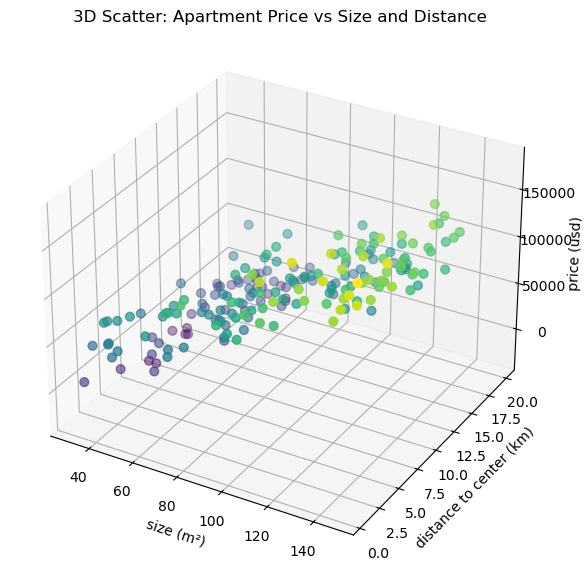

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3d plotting

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(size_m2, distance_to_center, prices,
           c=prices,  s=40)

ax.set_xlabel("size (m²)")
ax.set_ylabel("distance to center (km)")
ax.set_zlabel("price (usd)")

ax.set_title("3D Scatter: Apartment Price vs Size and Distance")

plt.show()



$$
y \;=\; b + w_1x_1 + w_2x_2 + \dots + w_p x_p + \varepsilon.
$$

### Векторная запись для одного наблюдения

Введём «расширенный» вектор признаков и веса:

$$
X \;=\; \begin{bmatrix}1\\ x_1\\ \vdots\\ x_p\end{bmatrix},
\qquad
W \;=\; \begin{bmatrix} b & w_1 & \dots & w_p \end{bmatrix}.
$$

Тогда

$$
y \;=\; W X + \varepsilon.
$$

### Матричная форма для выборки из $n$ наблюдений

Соберём дизайн-матрицу (первый столбец — единицы), $n$ это количество данных:

$$
\mathbf{X} \;=\;
\begin{bmatrix}
1 & x_{11} & \dots & x_{1p}\\
\vdots & \vdots & \ddots & \vdots\\
1 & x_{n1} & \dots & x_{np}
\end{bmatrix}\in\mathbb{R}^{n\times(p+1)},\quad
\mathbf{Y} \;=\;
\begin{bmatrix}
y_1\\ \vdots\\ y_n
\end{bmatrix}\in\mathbb{R}^{n\times 1}.
$$

Обозначим столбиковый вектор параметров

$$
\beta \;=\; \begin{bmatrix} b\\ w_1\\ \vdots\\ w_p\end{bmatrix}\in\mathbb{R}^{(p+1)\times 1}
\quad\text{(это просто }W^\top\text{).}
$$

Тогда модель: $\mathbf{Y} = \mathbf{X}\beta + \varepsilon$.

### Замкнутая формула

**MSE:** $\;J(\beta)=\tfrac1n\|\mathbf{Y}-\mathbf{X}\beta\|_2^2$.
Нормальные уравнения дают

$$
\hat\beta \;=\; (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{Y}
\quad
$$

а в исходном «строчном» обозначении

$$
\hat W \;=\; \hat\beta^\top.
$$



[Derivation.](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression)


In [16]:
class MulLinearRegression:
    def __init__(self):
        self.w = None        # vector of feature weights
        self.b = None        # intercept term (scalar)
        self.is_fitted = False
    
    def fit(self, X_train, y_train):
        X = X_train.astype(float)
        y = y_train.astype(float)

        # add a column of ones for the intercept term
        ones = np.ones((X.shape[0], 1), dtype=float)
        X_b = np.hstack([ones, X]) 

        # compute normal equation components
        XtX = X_b.T @ X_b           # X^T X
        Xty = X_b.T @ y             # X^T y

        # closed-form solution
        beta = np.linalg.inv(XtX) @ Xty

        # extract intercept and weights
        self.b = float(beta[0])       # first element is intercept
        self.w = beta[1:].reshape(-1) # rest are weights
        self.is_fitted = True
        return self

    def predict(self, X):
        X = X.astype(float)
        # linear model prediction: y = Xw + b
        y_pred = X @ self.w + self.b
        return y_pred


In [17]:
mymodel = MulLinearRegression()
mymodel.fit(X_train, y_train)


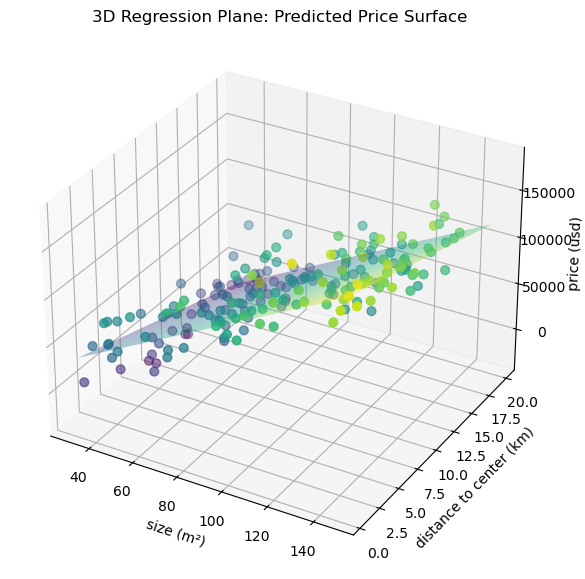

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume you already trained
# mymodel = MulLinearRegression()
# mymodel.fit(X_train, y_train)

# create a grid for the regression plane
size_grid, dist_grid = np.meshgrid(
    np.linspace(size_m2.min(), size_m2.max(), 30),
    np.linspace(distance_to_center.min(), distance_to_center.max(), 30)
)

# flatten grid and stack as feature matrix
X_plane = np.column_stack((size_grid.ravel(), dist_grid.ravel()))

# predict prices on the grid
y_plane = mymodel.predict(X_plane)
y_plane = y_plane.reshape(size_grid.shape)

# plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# scatter points
ax.scatter(size_m2, distance_to_center, prices,
           c=prices, s=40)

# regression plane
ax.plot_surface(size_grid, dist_grid, y_plane,
                cmap='viridis', alpha=0.4)

ax.set_xlabel("size (m²)")
ax.set_ylabel("distance to center (km)")
ax.set_zlabel("price (usd)")

ax.set_title("3D Regression Plane: Predicted Price Surface")

plt.show()
